In [192]:
import pandas as pd
import re
import datetime
import numpy as np
import matplotlib.pyplot as plt
import string 
import warnings
warnings.simplefilter('ignore')


In [193]:
def load_data(resume_path):
    df = pd.read_excel(resume_path)
    df.columns = [remove_space(name) for name in df.columns.to_list()]
    return df

In [195]:
def remove_space(text):
    text = re.sub(r'\s+$', '', text)
    text = re.sub(r'^\s+', '', text)
    return text

In [196]:
def cap_words(words):
    try:
        new_word = string.capwords(words)
        return new_word
    except AttributeError:
        return np.nan

In [239]:
string.capwords("OSL Retail Service")

'Osl Retail Service'

In [197]:
def find_competitor(company, competitor_lst):
    pat_comp =r'.*?(\b(?:{})\b).*?'.format('|'.join(competitor_lst))
    try:
        return re.match(pat_comp, company).group(1)
    except AttributeError:
        return np.nan
    except TypeError:
        return np.nan

In [198]:
def find_company(text, company):
    comp = [company]
    pat_comp =r'.*?(\b(?:{})\b).*?'.format('|'.join(comp))
    return bool(re.match(pat_comp, text))
    

In [200]:
def add_competitor_flag(df, colname_lst, competitor_lst):
    df2 = df[colname_lst]
    df2["work1_flag"] = df2.work1_company.apply(cap_words).apply(lambda x: find_competitor(x, competitor_lst))
    df2["work2_flag"] = df2.work2_company.apply(cap_words).apply(lambda x: find_competitor(x, competitor_lst))
    df2["work3_flag"] = df2.work3_company.apply(cap_words).apply(lambda x: find_competitor(x, competitor_lst))
    df2["work4_flag"] = df2.work4_company.apply(cap_words).apply(lambda x: find_competitor(x, competitor_lst))
    df2["work5_flag"] = df2.work5_company.apply(cap_words).apply(lambda x: find_competitor(x, competitor_lst))
    df2["work6_flag"] = df2.work6_company.apply(cap_words).apply(lambda x: find_competitor(x, competitor_lst))
    df2["work7_flag"] = df2.work7_company.apply(cap_words).apply(lambda x: find_competitor(x, competitor_lst))
    df3 = df2[["employee_code", "work1_flag", "work2_flag", "work3_flag", "work4_flag", "work5_flag", "work6_flag", "work7_flag"]]
    df3["competitor_experience"] = df3.apply(lambda row: 0 if 
                                             pd.isna(row.work1_flag) and 
                                             pd.isna(row.work2_flag) and 
                                             pd.isna(row.work3_flag) and
                                             pd.isna(row.work4_flag) and 
                                             pd.isna(row.work5_flag) and 
                                             pd.isna(row.work6_flag) and
                                             pd.isna(row.work7_flag)
                                             else 1, axis=1)
    return df3

In [201]:
def add_comp_flag(df, competitor_lst):
    for company in competitor_lst:
        df[company+"_competitor_exp"] = (df[["work1_flag", "work2_flag", "work3_flag", "work4_flag", "work5_flag", 
                                        "work6_flag", "work7_flag"]]
                                    .fillna("")
                                    .apply(lambda row: 1 if find_company(row["work1_flag"], company) or 
                                                            find_company(row["work2_flag"], company) or 
                                                            find_company(row["work3_flag"], company) or 
                                                            find_company(row["work4_flag"], company) or 
                                                            find_company(row["work5_flag"], company) or 
                                                            find_company(row["work6_flag"], company) or 
                                                            find_company(row["work7_flag"], company)
                                             else 0, axis=1))
    return df



In [264]:
resume = load_data("../data/20200603_manual_extraction_template.xlsx")
colname_lst = ["employee_code", "work1_company", "work2_company", "work3_company", 
               "work4_company", "work5_company", "work6_company", "work7_company"]
competitors = ['Freedom', 'Koodo', 'Shaw', 'Telus', 'Bell', 'Rogers', 'The Mobile Shop', 
        'Best Buy', 'Videotron', 'Wow[!]* Mobile', 'The Source', 'Walmart', 'Virgin Mobile', 'Osl']

df_final = add_comp_flag(add_competitor_flag(resume, colname_lst, competitors), competitors)



In [265]:
df_final.columns

Index(['employee_code', 'work1_flag', 'work2_flag', 'work3_flag', 'work4_flag',
       'work5_flag', 'work6_flag', 'work7_flag', 'competitor_experience',
       'Freedom_competitor_exp', 'Koodo_competitor_exp', 'Shaw_competitor_exp',
       'Telus_competitor_exp', 'Bell_competitor_exp', 'Rogers_competitor_exp',
       'The Mobile Shop_competitor_exp', 'Best Buy_competitor_exp',
       'Videotron_competitor_exp', 'Wow[!]* Mobile_competitor_exp',
       'The Source_competitor_exp', 'Walmart_competitor_exp',
       'Virgin Mobile_competitor_exp', 'Osl_competitor_exp'],
      dtype='object')

In [266]:
df_final[df_final.employee_code=="N7U"] # 1 Yes 0 No 

,employee_code,work1_flag,work2_flag,work3_flag,work4_flag,work5_flag,work6_flag,work7_flag,competitor_experience,Freedom_competitor_exp,...,Bell_competitor_exp,Rogers_competitor_exp,The Mobile Shop_competitor_exp,Best Buy_competitor_exp,Videotron_competitor_exp,Wow[!]* Mobile_competitor_exp,The Source_competitor_exp,Walmart_competitor_exp,Virgin Mobile_competitor_exp,Osl_competitor_exp
252,N7U,NaN,The Mobile Shop,Osl,NaN,NaN,NaN,NaN,1,0,...,0,0,1,0,0,0,0,0,0,1


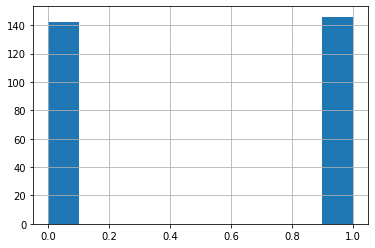

In [267]:
df_final.competitor_experience.hist()
plt.show()

In [250]:
df_final.to_csv("../result/competitor_experience.csv", index=False)